In [ ]:
#Paper
#https://arxiv.org/pdf/1809.00219.pdf

#Github
#https://github.com/captain-pool/GSOC/

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tqdm
import os
import shutil
import re
import cv2
import time
import logging
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/ESRGAN'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-ZqB07DE3ix8YhVuDmqf9Fc8sYXU-tZO/ESRGAN


In [3]:
#Import ESRGAN model
SAVED_MODEL_PATH = "https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz"#"https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

#Import data
data=tfds.load('aflw2k3d')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/aflw2k3d/1.0.0.incompletePVG2EK/aflw2k3d-train.tfrecord


  0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset aflw2k3d downloaded and prepared to /root/tensorflow_datasets/aflw2k3d/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_data=data['train'].skip(600)
test_data=data['train'].take(600)
tqdm.tqdm(train_data)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [5]:
@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(data['image'] / 255,tf.float32)

  lr=tf.image.resize(cropped,(128,128))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

In [16]:

generator = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/captain-pool/esrgan-tf2/1", trainable=True),
    tf.keras.layers.Conv2D(filters=3, kernel_size=[1, 1], strides=[1, 1])
])
loaded_1 = tf.keras.models.load_model(
    "esrGan_trained.h5", custom_objects={"CustomModel": generator}
)
# loaded_2 = tf.keras.models.load_model("esrGan_trained.h5")
# generator.set_weights(tf.keras.models.load_model('esrGan_trained.h5'))

ValueError: ignored

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 6, image_size[1] // 6],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

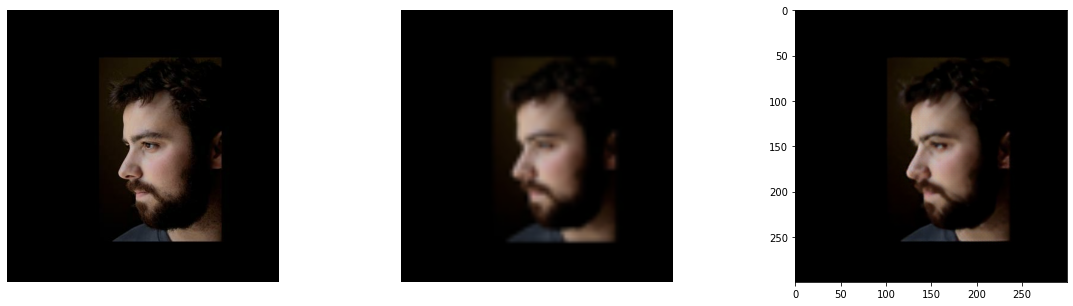

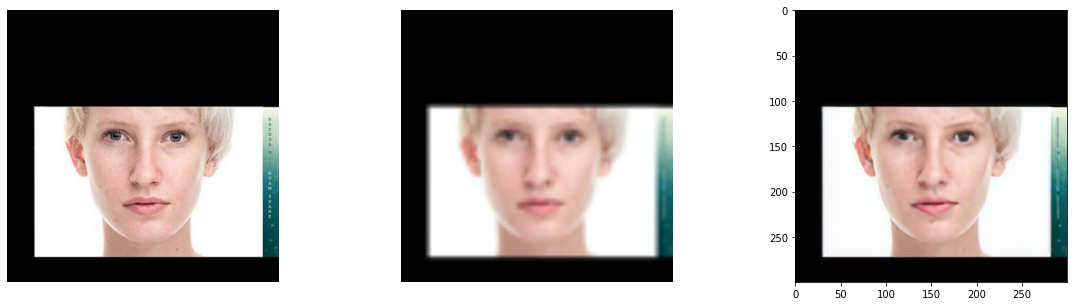

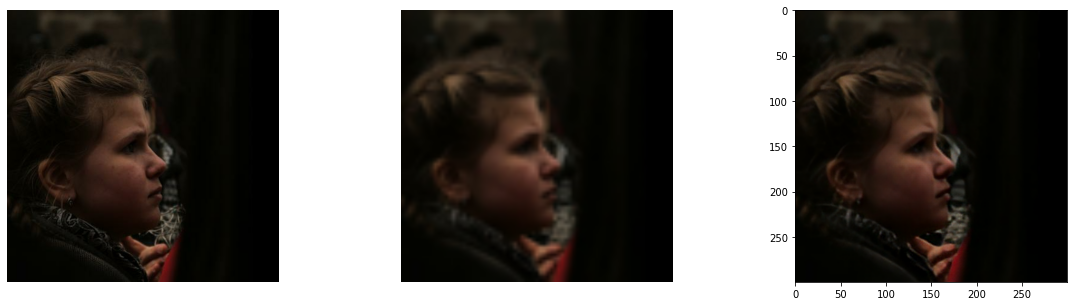

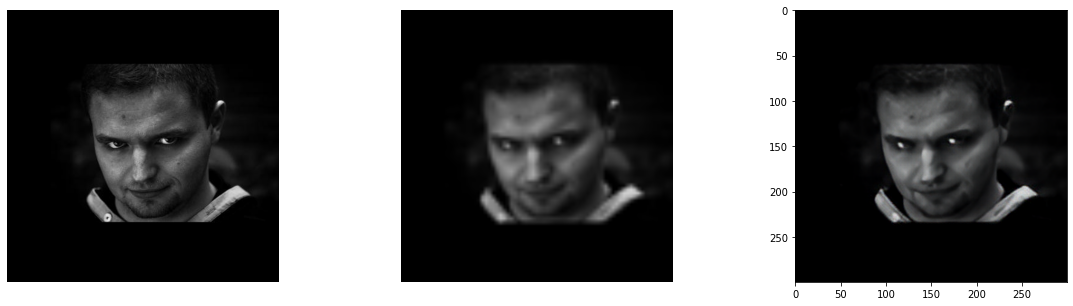

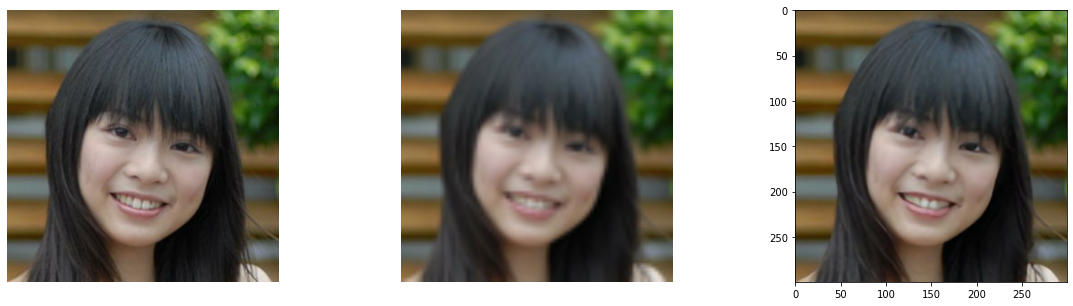

In [ ]:
for x in train_data.take(5):

  fig=plt.figure(figsize=(20,5))

  #plot original image
  plt.subplot(1,3,1)
  plt.imshow(x['image'])
  plt.axis('off')

  #Plot downsampled image
  plt.subplot(1,3,2)
  lr=downscale_image(x['image'])
  plt.imshow(tf.image.resize(tf.squeeze(lr/255),(512,512)))
  plt.axis('off')

  #Plot the output of the model
  plt.subplot(1,3,3)
  plt.imshow(tf.cast(tf.clip_by_value(tf.squeeze(model(lr)), 0, 255), tf.uint8))
  plt.axis('on')
  plt.show()
